# **WGAN and DCGAN for Fashion-Mnist**

## **Initialization**

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import grad
from torch.functional import Tensor
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

In [12]:
from google.colab import drive
drive.mount("/content/gdrive")

PATH = "/content/gdrive/MyDrive/ex3_313581803_314882861/Q3.4"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ITERS = 50000
LAMBDA = 10
SAMPLE_SIZE = 28
NUM_OF_CHANNELS = 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Load Data**
Get mnist-fashion data from https://github.com/zalandoresearch/fashion-mnist.

In [13]:
torch.manual_seed(42)

train_set = datasets.FashionMNIST(
    root = f'{PATH}/Data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))                                
    ])
)
test_set = datasets.FashionMNIST(
    root = f'{PATH}/Data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))                           
    ])
)

def train_loader_generator(batch_size):
    while True:
      train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
      for samples, _ in train_loader:
        yield samples

### **Network Architecture**

Implement W-GAN and DC-GAN for Fashion-Mnist


In [14]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.feature_size = 64
        self.latent_size = 100
        self.fc = nn.Sequential( 
            nn.Linear(self.latent_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.feature_size * 2, self.feature_size, 4, 2, 1),
            nn.BatchNorm2d(self.feature_size),
            nn.ConvTranspose2d(self.feature_size, 1, 4, 2, 1),
            nn.Tanh()
        )
        initialize_weights(self)


    def forward(self, input=None, batch_size=0):
      if input is None:
        input = torch.randn((batch_size, self.latent_size)).to(DEVICE)
      input = self.fc(input).view(-1, 128, 7, 7)
      return self.conv(input)


class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.feature_size = 64
        self.conv = nn.Sequential( # input.shape = 1x28x28
            nn.Conv2d(NUM_OF_CHANNELS, self.feature_size, 4, 2, 1), # 64x14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.feature_size, self.feature_size*2, 4, 2, 1),
            nn.BatchNorm2d(self.feature_size*2),
            nn.LeakyReLU(0.2),
          )
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1)
        )

    def forward(self, input):
        input = self.conv(input).view(-1, 128 * 7*7)
        return self.fc(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.critic = Critic()
        self.sigmoid = nn.Sigmoid() 
        initialize_weights(self)

    def forward(self, input):
        input = self.critic(input)
        return self.sigmoid(input)


In [15]:
class WGAN(nn.Module):
    def __init__(self, ngpu=1):
        super(WGAN, self).__init__()
        self.batch_size = 64
        self.num_critics = 5
        self.generator = Generator().to(DEVICE)
        self.discriminator = Critic().to(DEVICE)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0, 0.9))
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0001, betas=(0, 0.9))
        initialize_weights(self)
      
    def discriminator_loss(self, real, fake):
        epsilon = torch.zeros(len(real), 1, 1, 1).uniform_(0, 1).to(DEVICE)
        pred_real = self.discriminator(real).mean()
        pred_fake = self.discriminator(fake).mean()
        # Gradient Panelty 
        interpolation = epsilon * real.data + (1-epsilon) * fake.data
        interpolation.requires_grad = True
        pred_interpolation = self.discriminator(interpolation)
        interpolation_grad = grad(outputs=pred_interpolation, inputs=interpolation, 
                                  grad_outputs=torch.ones(pred_interpolation.shape).to(DEVICE), 
                                  retain_graph=True, create_graph=True)[0]
        gradient_penalty = ((interpolation_grad.view(interpolation_grad.shape[0], -1).norm(2, 1) - 1) ** 2).mean()
        return pred_fake - pred_real + LAMBDA*gradient_penalty

    def generator_loss(self, fake):
        L = self.discriminator(fake)
        return -L.mean()



class DCGAN(nn.Module):
    def __init__(self, ngpu = 1):
        super(DCGAN, self).__init__()
        self.batch_size = 124
        self.num_critics = 1
        self.generator = Generator().to(DEVICE)
        self.discriminator = Discriminator().to(DEVICE)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.criterion = nn.BCELoss(reduction='mean').to(DEVICE)
        initialize_weights(self)

    def discriminator_loss(self, real, fake):
        pred_real = self.discriminator(real)
        real_loss = self.criterion(pred_real, torch.ones(pred_real.shape).to(DEVICE))
        pred_fake = self.discriminator(fake)
        fake_loss = self.criterion(pred_fake, torch.zeros(pred_fake.shape).to(DEVICE))
        return real_loss + fake_loss

    def generator_loss(self, fake):
        pred_fake = self.discriminator(fake)
        return self.criterion(pred_fake, torch.ones(pred_fake.shape).to(DEVICE))


def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm2d, nn.Conv2d, nn.ConvTranspose2d)):
            m.weight.data.normal_(0, 0.02)
            

## **Train Models** 

In [6]:
def fit(model, file_name, save_model=False):
    check_noise = torch.randn((12, model.generator.latent_size)).to(DEVICE)
    results = []
    model.generator.train()
    model.discriminator.train()
    real_iter = train_loader_generator(model.batch_size)
    for iter in range(ITERS):
        real = real_iter.__next__().to(DEVICE)
        # Train the discriminator
        for _ in range(model.num_critics):
            fake = model.generator(batch_size=len(real))
            d_loss = model.discriminator_loss(real, fake)
            model.discriminator_optimizer.zero_grad()
            d_loss.backward(retain_graph=True)
            model.discriminator_optimizer.step()
        # Train the generator
        g_loss = model.generator_loss(fake)
        model.generator_optimizer.zero_grad()
        g_loss.backward()
        model.generator_optimizer.step()
        results.append((g_loss.item(), d_loss.item()))
        if iter == 1000 or (iter + 1) % 5000 == 0:
            print(f"iteration: {iter}, gen loss: {g_loss}, dis loss: {d_loss}")
            show_images(model.generator, iter, check_noise)
        if (iter + 1) % 10000 == 0:
          torch.save(model.state_dict(),f"{PATH}/Models/{file_name}_{iter}.pt")
          generate_plots(results, file_name=f"{file_name}_{iter}")
    
    if save_model:
        torch.save(model.state_dict(),f"{PATH}/Models/{file_name}_{iter}.pt")
        show_images(model.generator, noise=check_noise, file_name=file_name)
    generate_plots(results, file_name)
    return results


def generate_plots(results, file_name):
    with open(f"{PATH}/Results/{file_name}_results", 'wb') as f:
      np.save(f, results)

    plt.xlabel("Iterations")
    plt.ylabel("loss")
    x = np.arange(len(results))
    X_=np.linspace(x.min(), x.max(), 100)

    y_gen = np.array(results)[:,0]
    gen_interploation = interp1d(x, y_gen, kind = "cubic")
    Y_gen_=gen_interploation(X_)
    plt.plot(X_, Y_gen_, label='Generator Loss')

    y_dis = np.array(results)[:,1]
    dis_interploation = interp1d(x, y_dis, kind = "cubic")
    Y_dis_=dis_interploation(X_)
    plt.plot(X_, Y_dis_, label='Discriminator Loss')
    plt.title('Loss per epoch')
    plt.legend()
    plt.grid()


    plt.savefig(f'{PATH}/Results/{file_name}_graph.png', bbox_inches='tight')
    plt.close()

def show_images(gen_model, iter=0, noise=None, file_name=None):
    # Smaple from the Generator and save the results
    with torch.no_grad():
      gen_model.eval()
      rows = 3
      columns = 4
      images = gen_model(noise)
      f, axarr = plt.subplots(rows, columns, figsize=(12, 8))
      for i in range(rows):
        for j in range(columns):
          axarr[i,j].imshow(images[i*columns+j].cpu().detach().numpy().reshape(28,28), cmap='gray', vmin=-1, vmax=1)
          axarr[i,j].axis('off')
      if file_name is not None:
        plt.savefig(f'{PATH}/Results/{file_name}_images.png', bbox_inches='tight')
      plt.show()

### **DCGAN**

iteration: 1000, gen loss: 4.132176399230957, dis loss: 0.017896395176649094


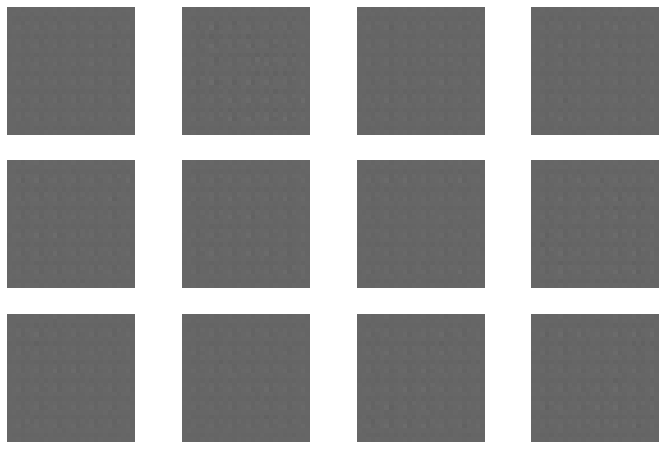

iteration: 4999, gen loss: 6.651791095733643, dis loss: 0.0032819625921547413


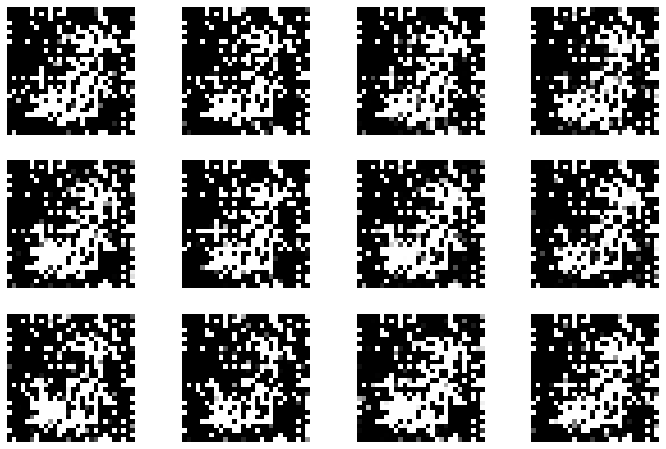

iteration: 9999, gen loss: 4.9535017013549805, dis loss: 0.02107181027531624


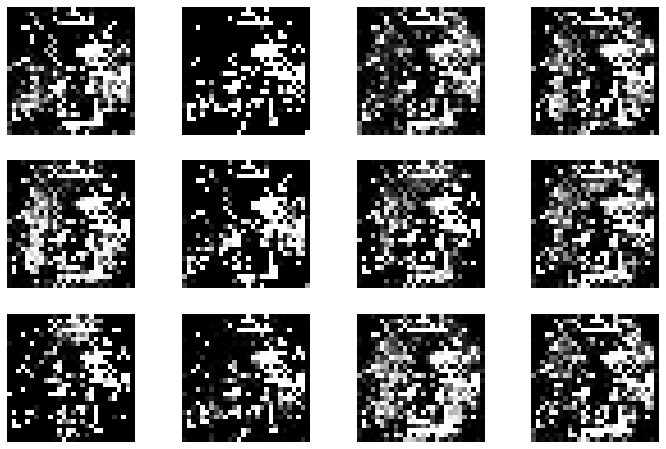

iteration: 14999, gen loss: 2.7685022354125977, dis loss: 0.5149217844009399


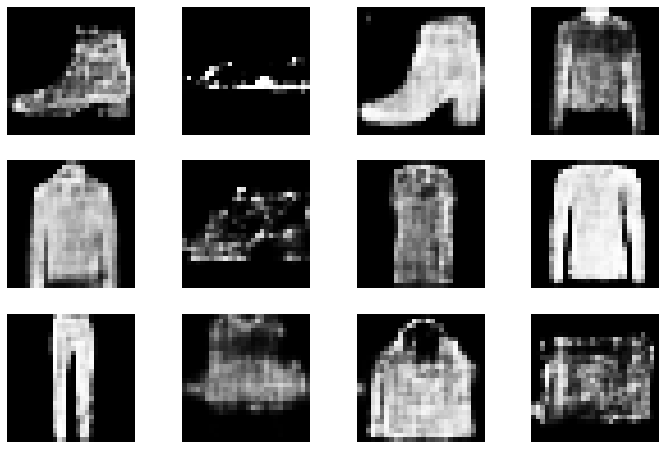

iteration: 19999, gen loss: 2.390784740447998, dis loss: 0.49675577878952026


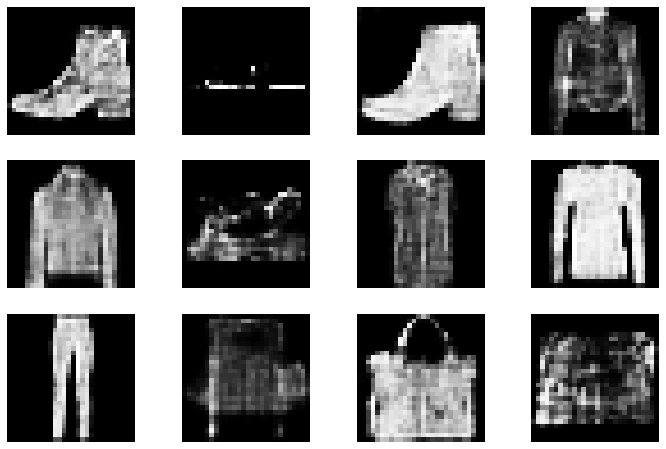

iteration: 24999, gen loss: 2.767327070236206, dis loss: 0.42030516266822815


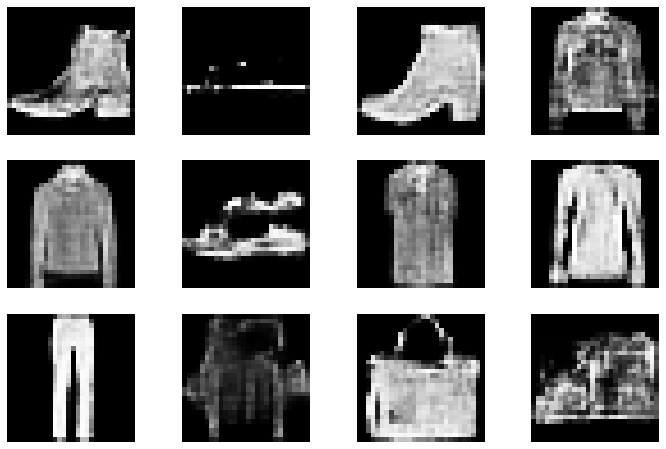

iteration: 29999, gen loss: 2.6795718669891357, dis loss: 0.3716684877872467


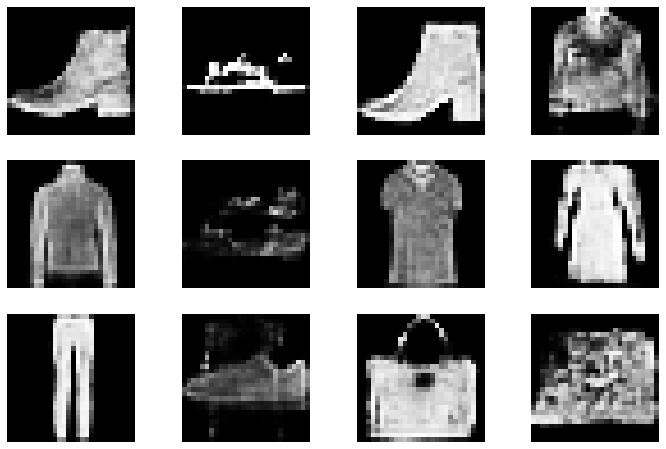

iteration: 34999, gen loss: 3.6808218955993652, dis loss: 0.335453599691391


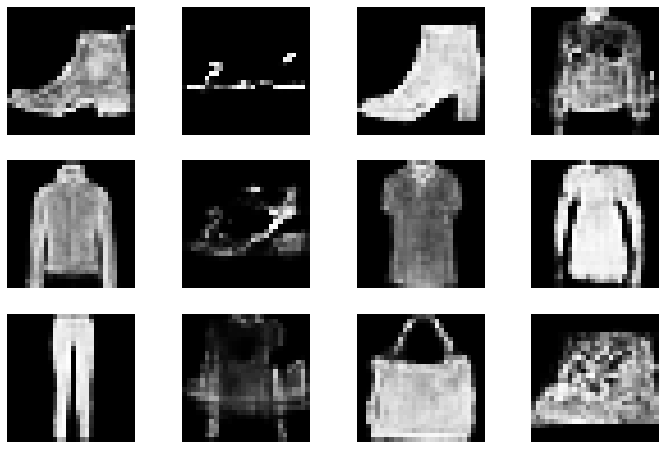

iteration: 39999, gen loss: 3.4812142848968506, dis loss: 0.47152602672576904


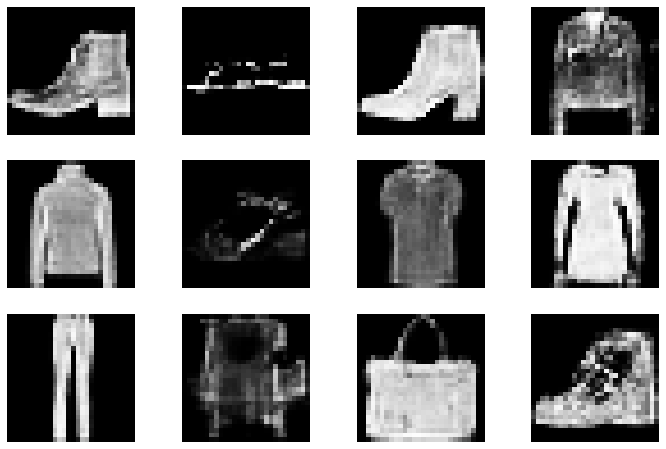

iteration: 44999, gen loss: 2.9357457160949707, dis loss: 0.3680688738822937


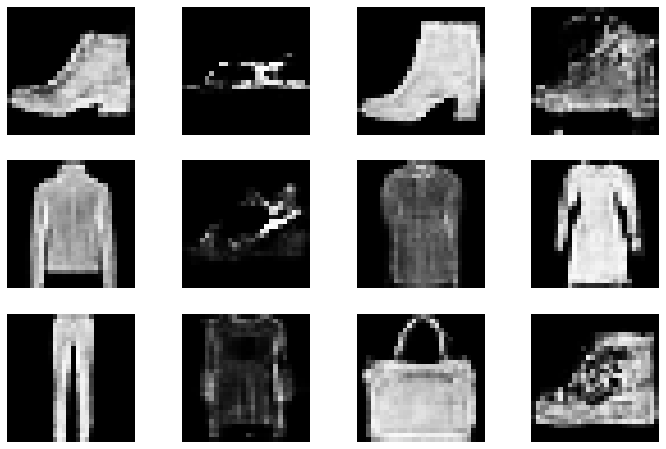

iteration: 49999, gen loss: 3.3620967864990234, dis loss: 0.2596944570541382


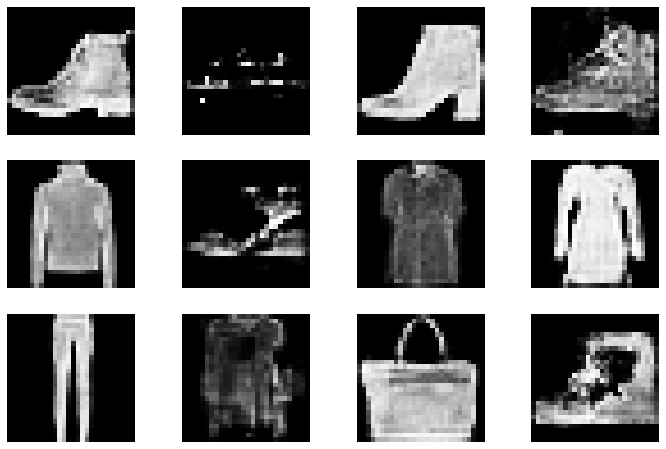

iteration: 54999, gen loss: 4.8179931640625, dis loss: 0.31290796399116516


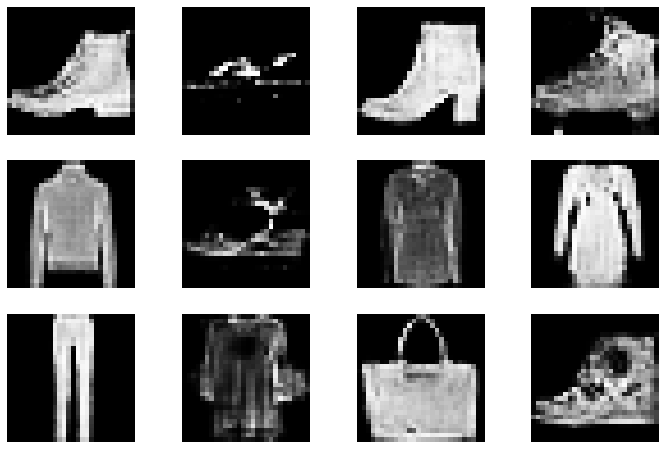

iteration: 59999, gen loss: 3.5886292457580566, dis loss: 0.295833945274353


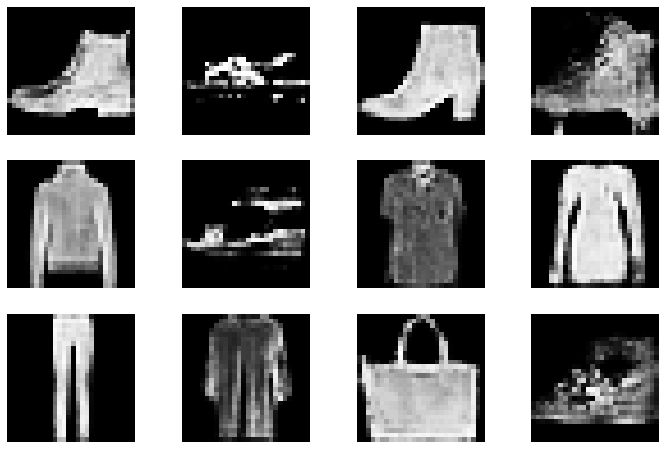

iteration: 64999, gen loss: 4.711517810821533, dis loss: 0.25157278776168823


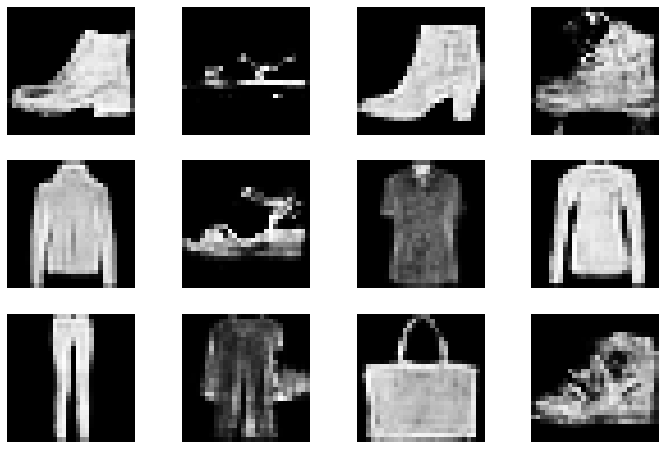

iteration: 69999, gen loss: 4.948266506195068, dis loss: 0.22306060791015625


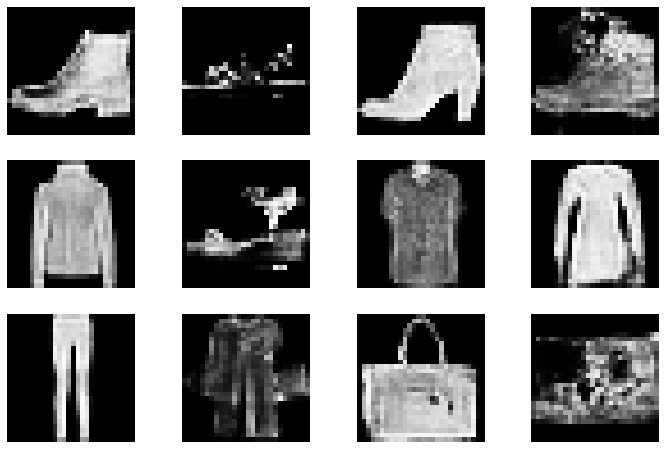

iteration: 74999, gen loss: 4.536585330963135, dis loss: 0.26258206367492676


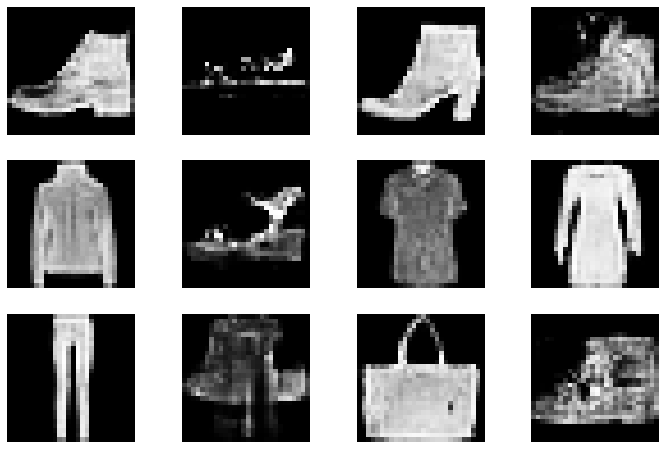

iteration: 79999, gen loss: 4.462541580200195, dis loss: 0.2156323492527008


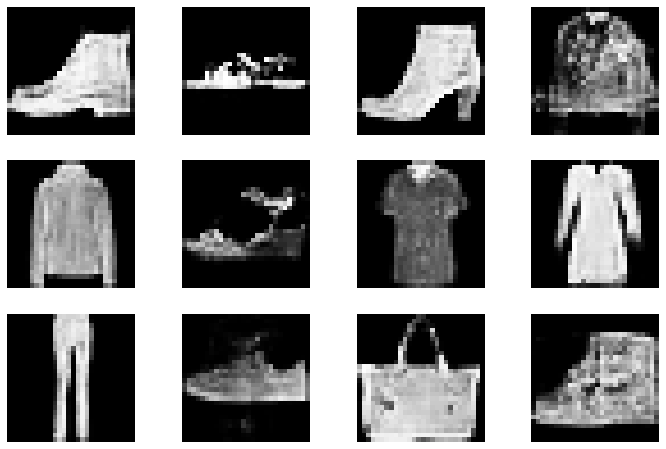

iteration: 84999, gen loss: 4.95308780670166, dis loss: 0.1368463933467865


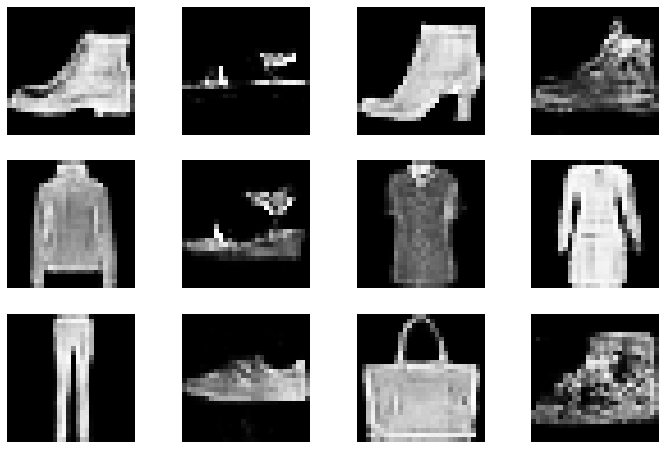

iteration: 89999, gen loss: 5.436614036560059, dis loss: 0.24209792912006378


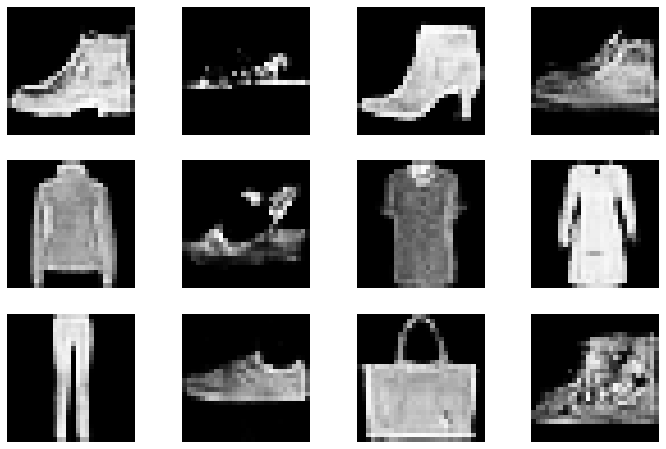

iteration: 94999, gen loss: 5.5888590812683105, dis loss: 0.20188945531845093


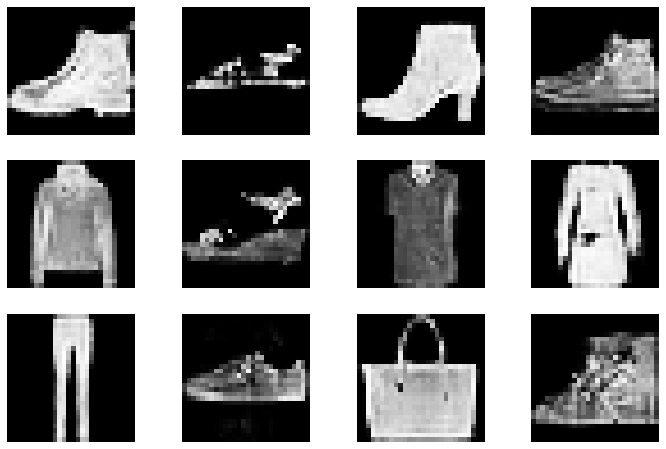

iteration: 99999, gen loss: 5.882599830627441, dis loss: 0.10183760523796082


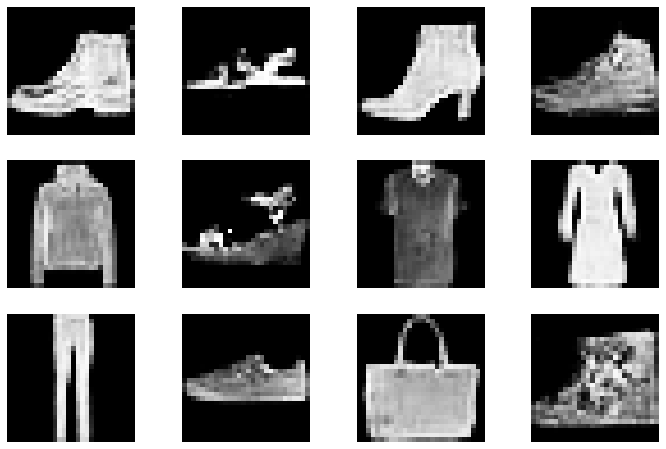

iteration: 104999, gen loss: 5.194433212280273, dis loss: 0.3150290548801422


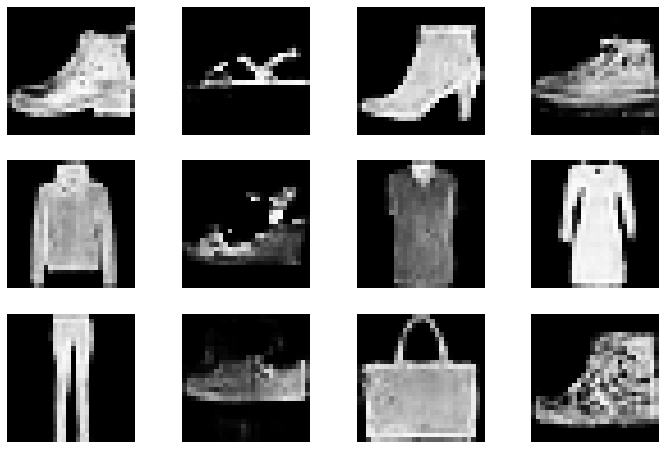

iteration: 109999, gen loss: 5.466113567352295, dis loss: 0.21460652351379395


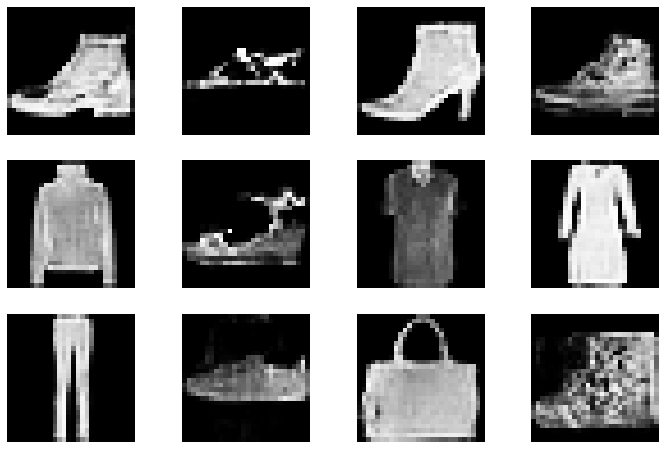

iteration: 114999, gen loss: 5.996297836303711, dis loss: 0.13521398603916168


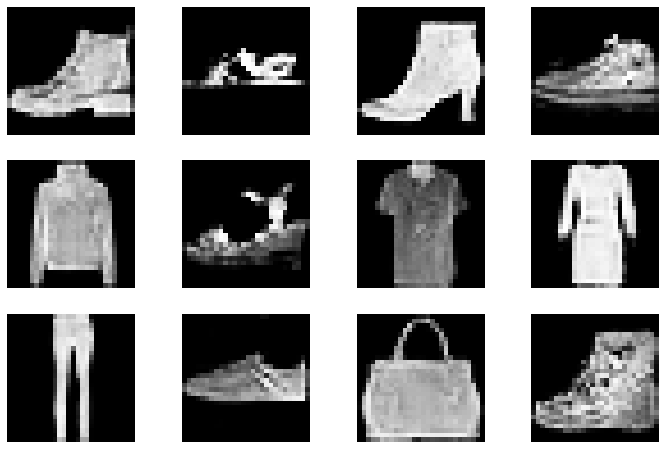

iteration: 119999, gen loss: 5.953978538513184, dis loss: 0.11930574476718903


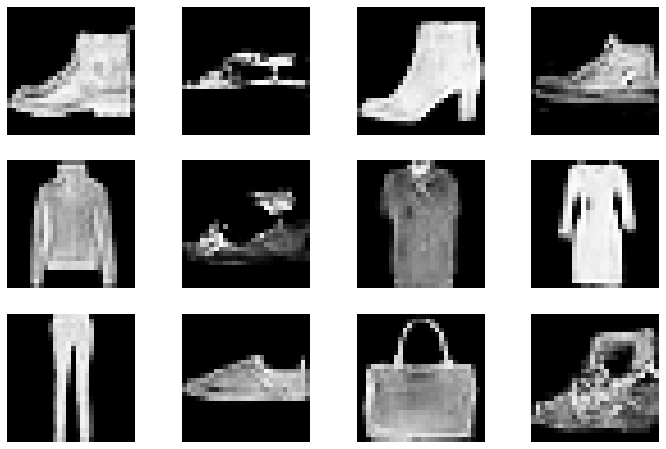

iteration: 124999, gen loss: 6.7832865715026855, dis loss: 0.1043407991528511


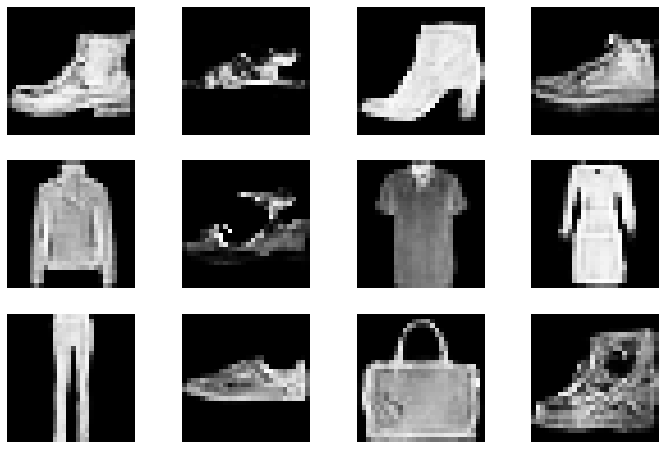

iteration: 129999, gen loss: 6.493088245391846, dis loss: 0.12922869622707367


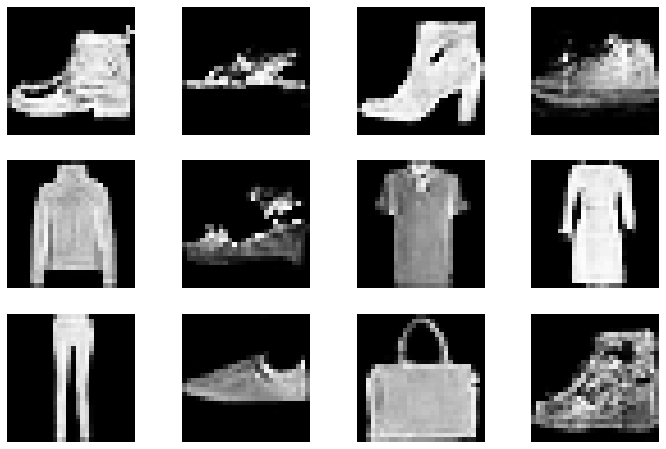

iteration: 134999, gen loss: 6.382862567901611, dis loss: 0.0962405800819397


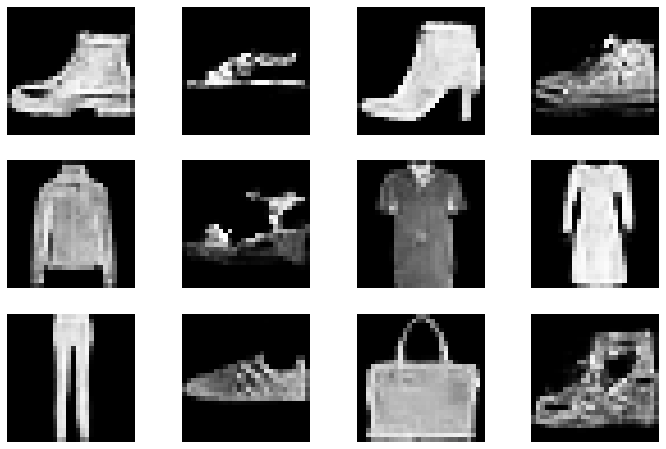

iteration: 139999, gen loss: 6.394435405731201, dis loss: 0.1440669596195221


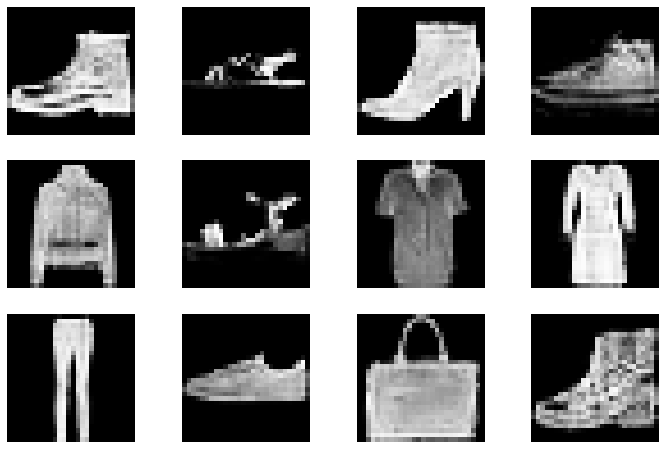

iteration: 144999, gen loss: 6.844714641571045, dis loss: 0.10232119262218475


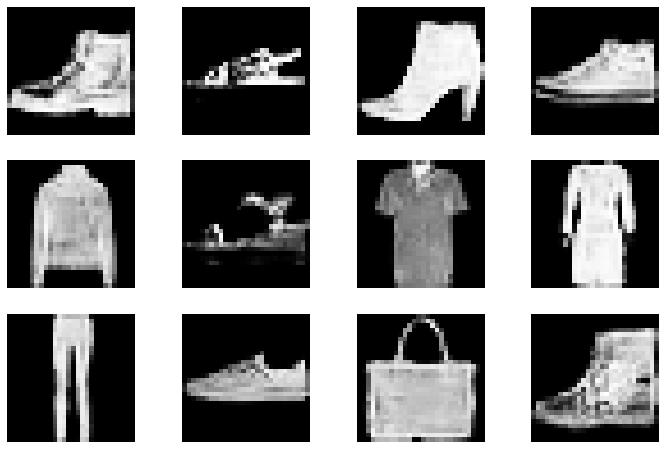

iteration: 149999, gen loss: 6.51475191116333, dis loss: 0.11391618847846985


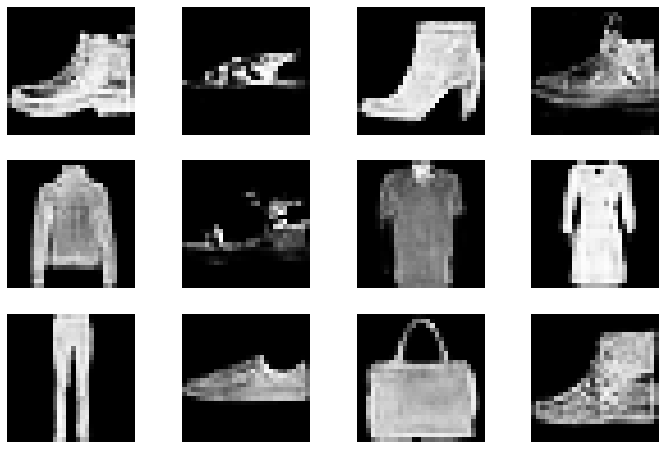

iteration: 154999, gen loss: 7.064548969268799, dis loss: 0.05343464016914368


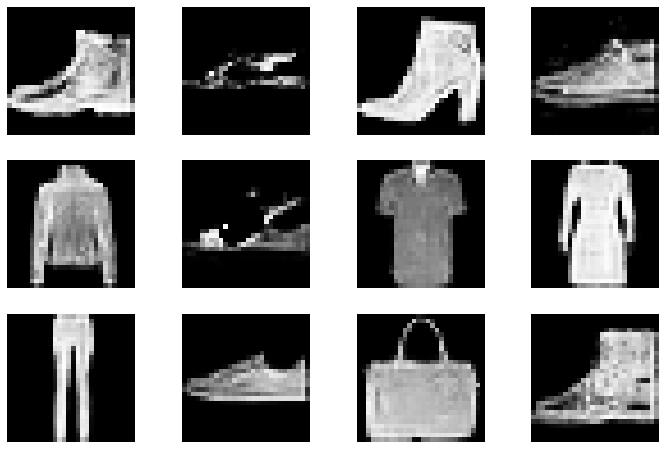

iteration: 159999, gen loss: 7.803170204162598, dis loss: 0.12691408395767212


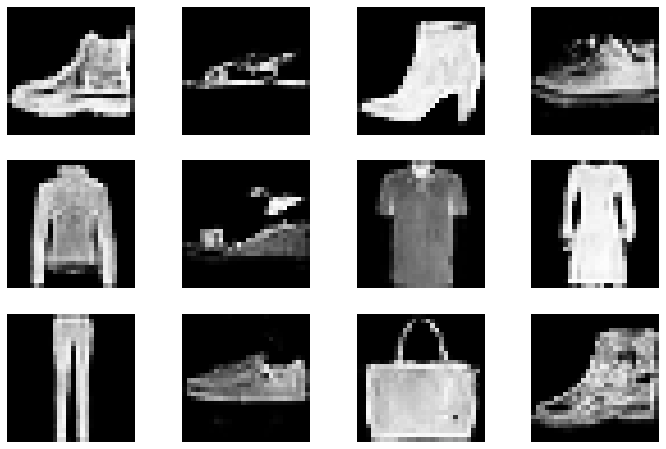

iteration: 164999, gen loss: 7.549490928649902, dis loss: 0.11648498475551605


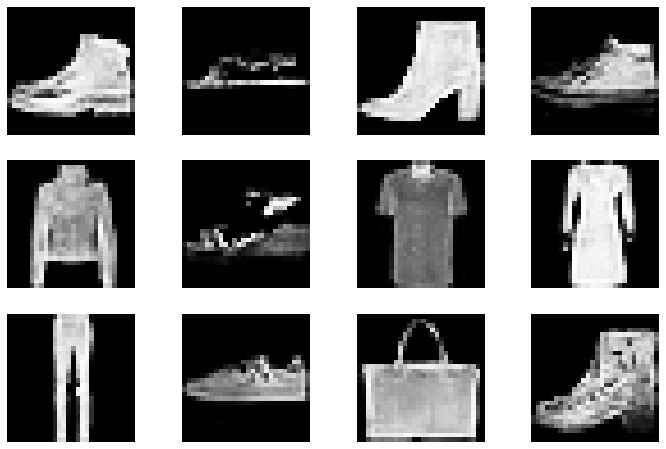

iteration: 169999, gen loss: 8.109033584594727, dis loss: 0.10465587675571442


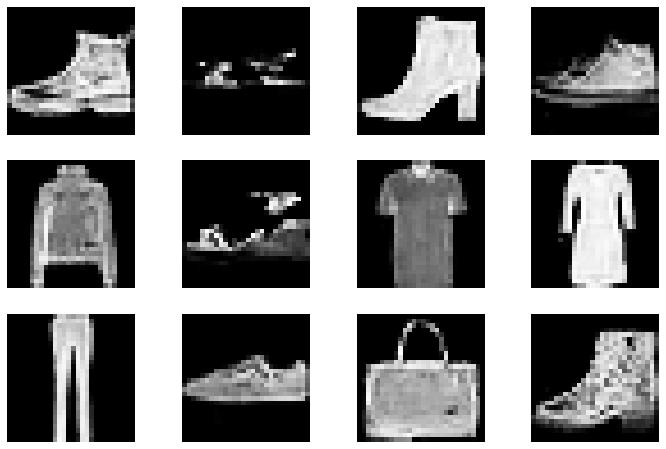

iteration: 174999, gen loss: 6.851039409637451, dis loss: 0.13797526061534882


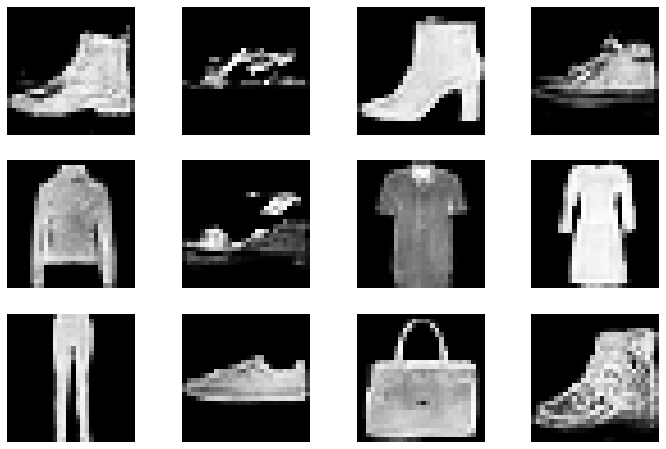

iteration: 179999, gen loss: 8.060522079467773, dis loss: 0.08993947505950928


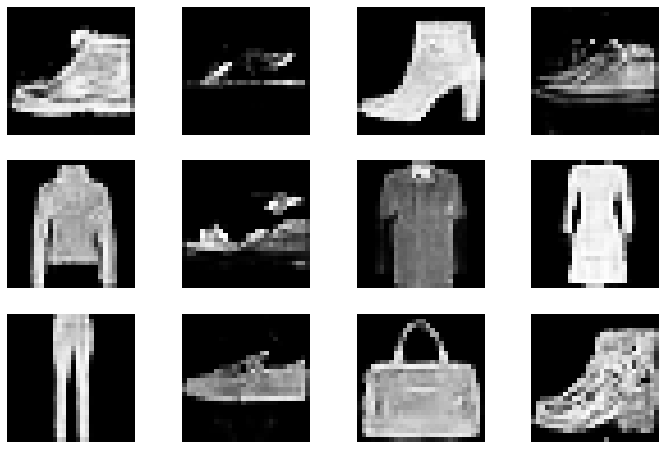

iteration: 184999, gen loss: 7.927849769592285, dis loss: 0.07135400176048279


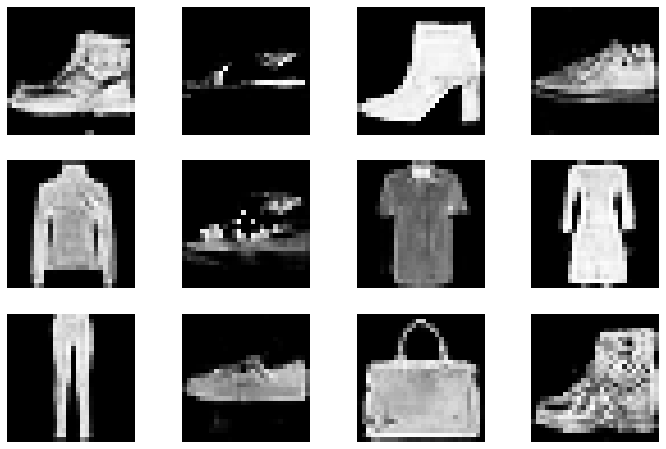

iteration: 189999, gen loss: 7.330402851104736, dis loss: 0.0642918050289154


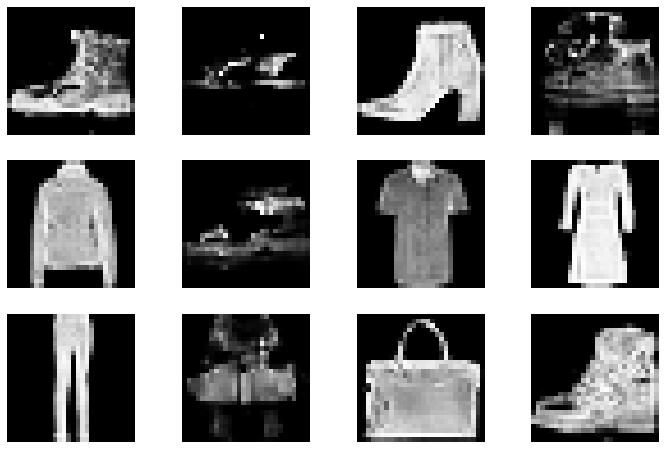

iteration: 194999, gen loss: 8.285764694213867, dis loss: 0.07609939575195312


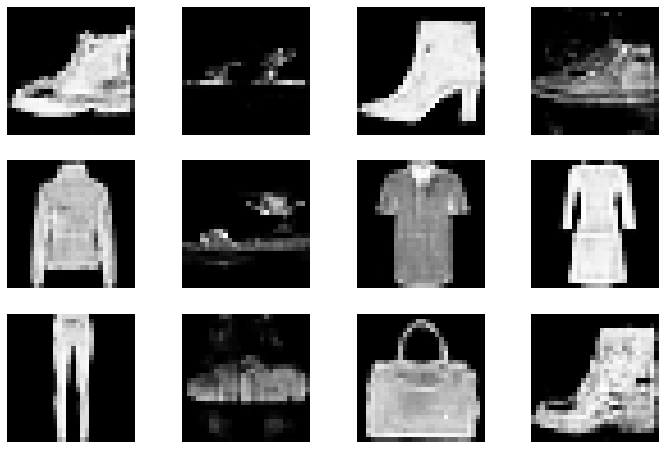

iteration: 199999, gen loss: 8.464496612548828, dis loss: 0.10147428512573242


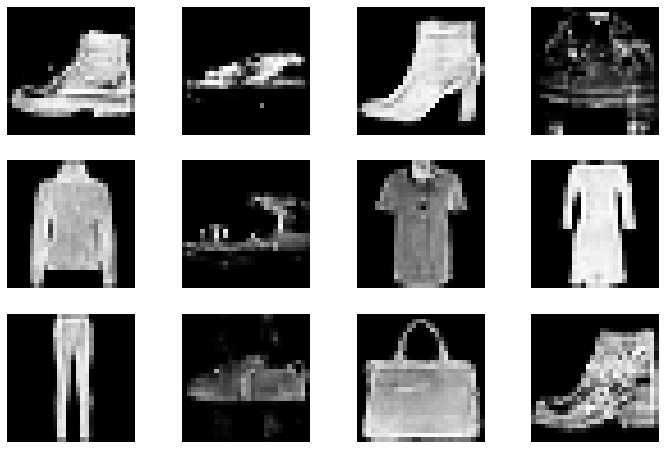

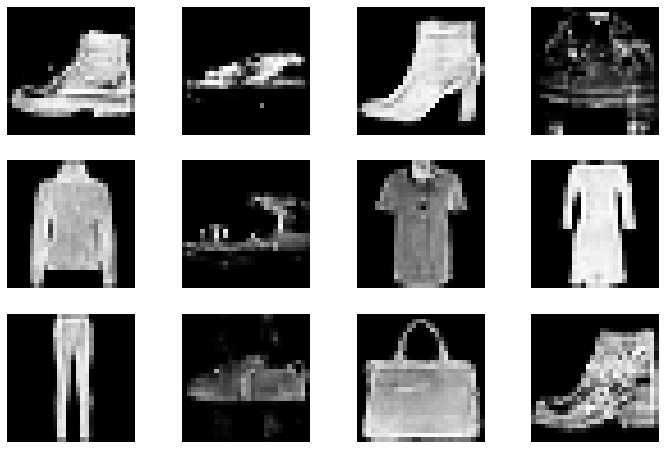

In [ ]:
if not os.path.exists(f"{PATH}/Models/DCGAN"):
    os.mkdir(f"{PATH}/Models/DCGAN")
if not os.path.exists(f"{PATH}/Results/DCGAN"):
    os.mkdir(f"{PATH}/Results/DCGAN")

file_name = "DCGAN_test"

model = DCGAN().to(DEVICE)
results = fit(model, file_name=f"DCGAN/{file_name}", save_model=True)
   

### **WGAN**

iteration: 1000, gen loss: 8.194482803344727, dis loss: -14.366470336914062


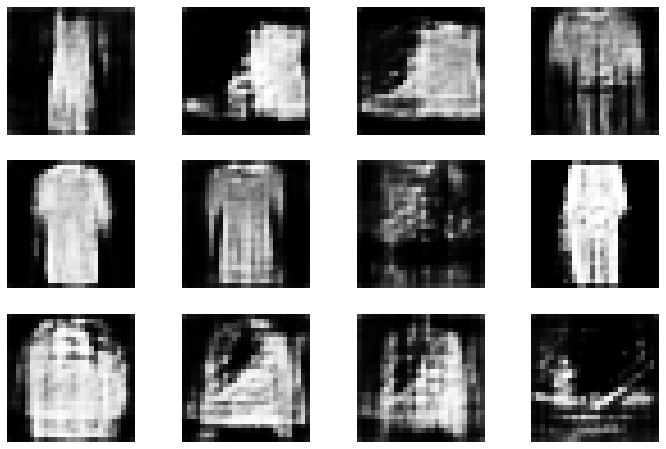

iteration: 4999, gen loss: -7.690269470214844, dis loss: -27.358291625976562


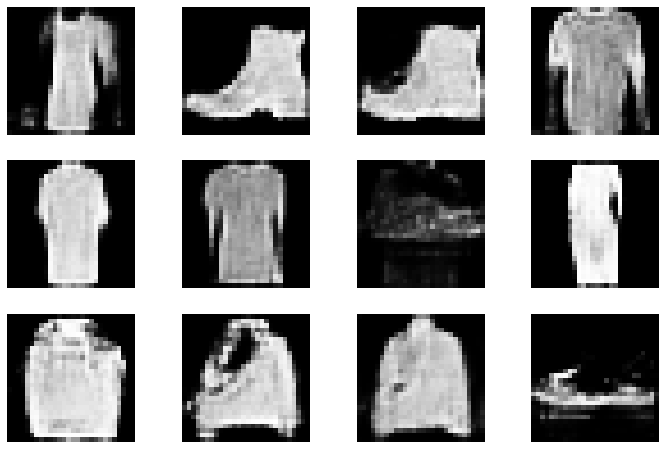

iteration: 9999, gen loss: -25.9984130859375, dis loss: -20.21044921875


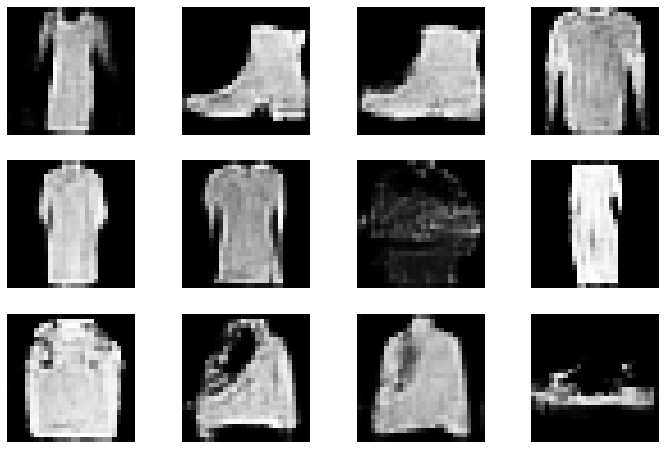

iteration: 14999, gen loss: -31.995349884033203, dis loss: 3.8668861389160156


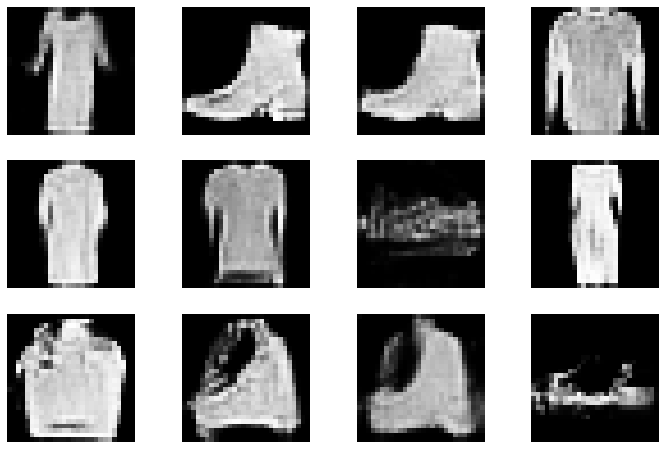

iteration: 19999, gen loss: -47.805747985839844, dis loss: -26.87588882446289


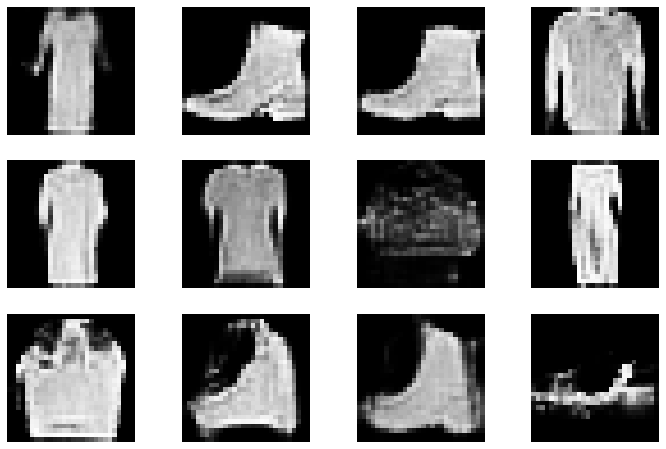

iteration: 24999, gen loss: -34.468421936035156, dis loss: -10.532669067382812


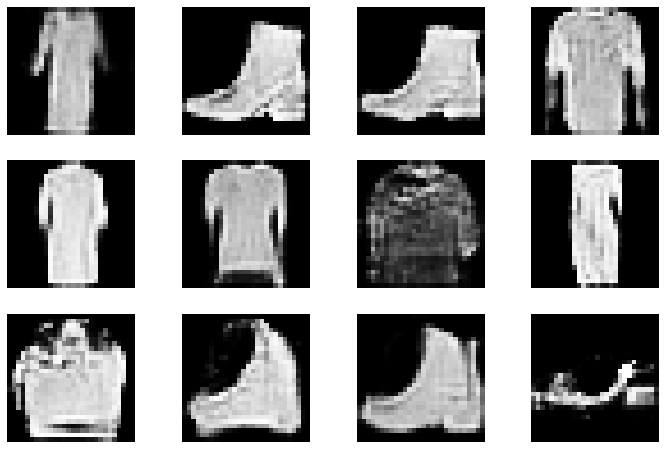

iteration: 29999, gen loss: -17.050060272216797, dis loss: -24.143531799316406


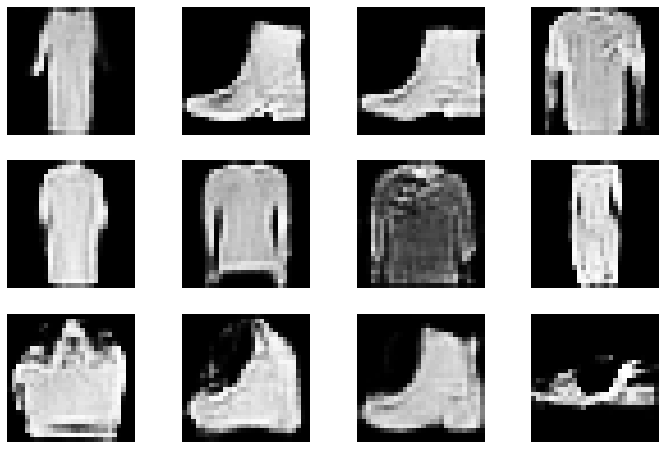

iteration: 34999, gen loss: -42.665733337402344, dis loss: -19.931400299072266


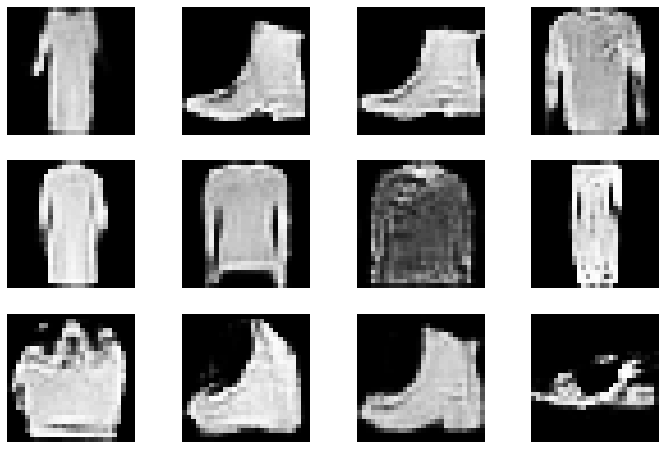

iteration: 39999, gen loss: -33.07318878173828, dis loss: -14.540921211242676


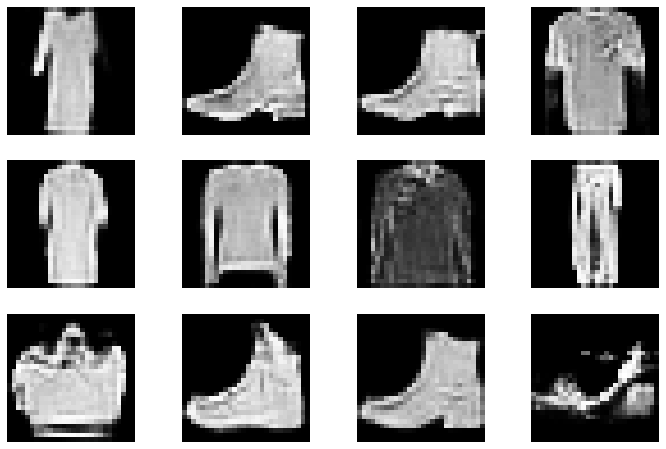

iteration: 44999, gen loss: -12.210857391357422, dis loss: 0.02477407455444336


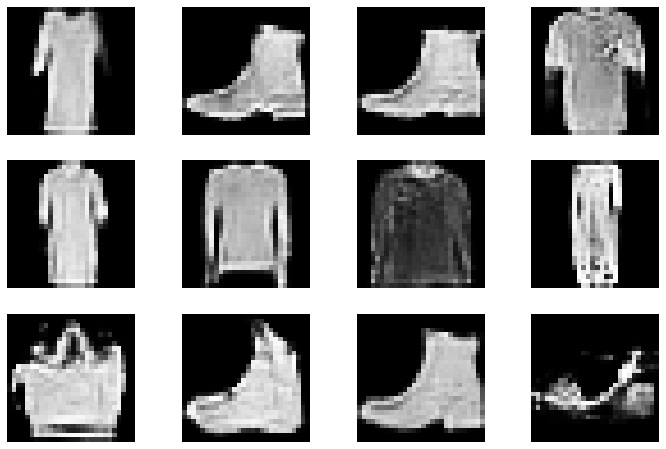

iteration: 49999, gen loss: -12.154020309448242, dis loss: -7.334847927093506


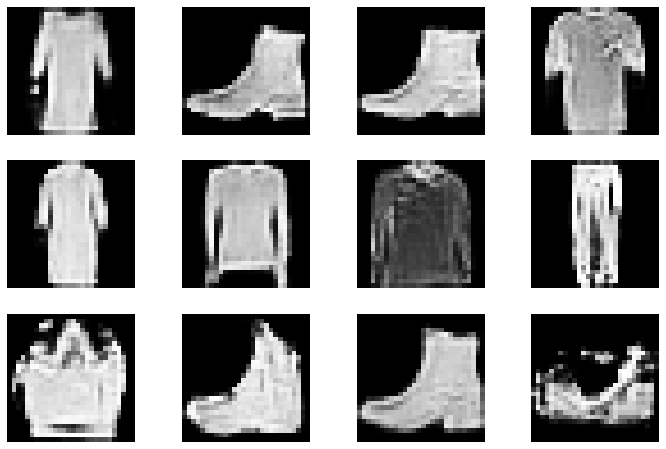

iteration: 54999, gen loss: -13.285865783691406, dis loss: -16.738494873046875


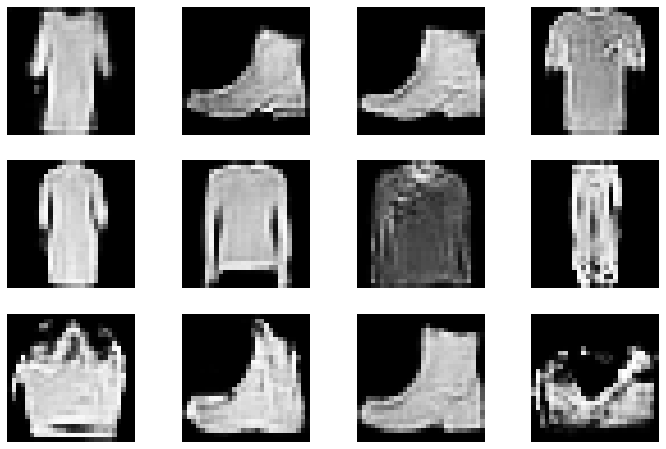

iteration: 59999, gen loss: -27.585052490234375, dis loss: -20.98349952697754


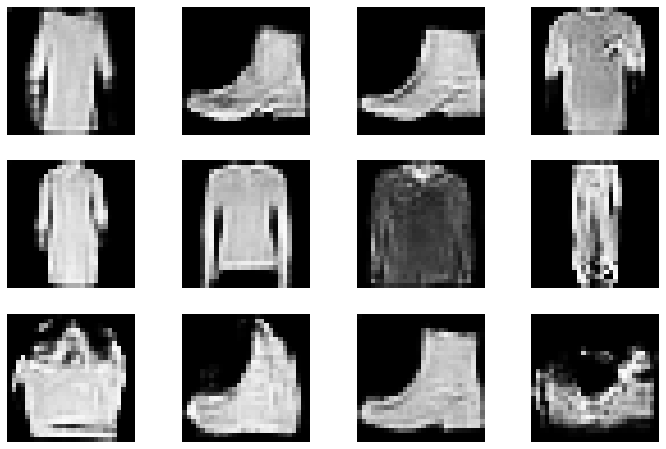

iteration: 64999, gen loss: -23.55695343017578, dis loss: -14.557084083557129


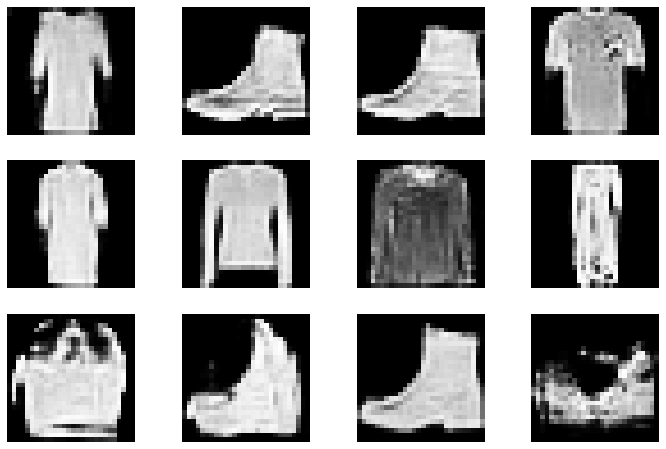

iteration: 69999, gen loss: -37.733055114746094, dis loss: -2.0630135536193848


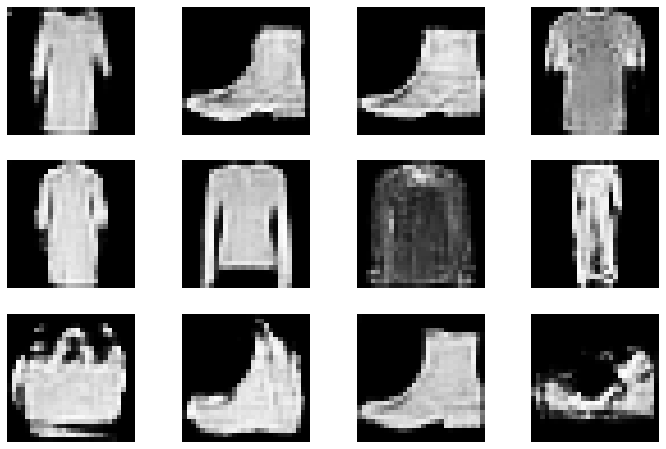

iteration: 74999, gen loss: -18.101673126220703, dis loss: 0.4454770088195801


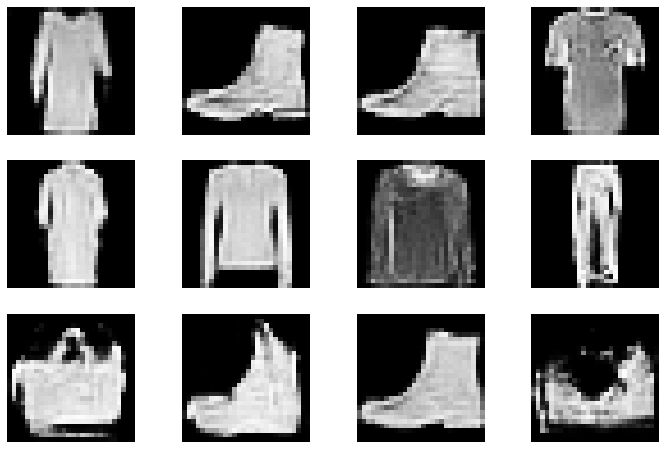

iteration: 79999, gen loss: -27.293136596679688, dis loss: -11.985371589660645


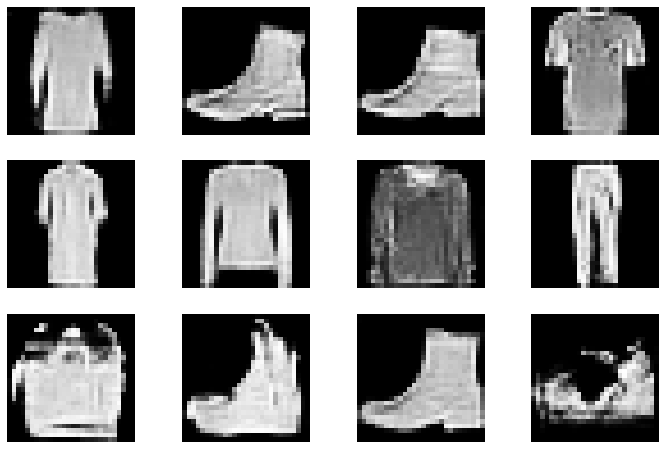

iteration: 84999, gen loss: -37.543975830078125, dis loss: -5.365421772003174


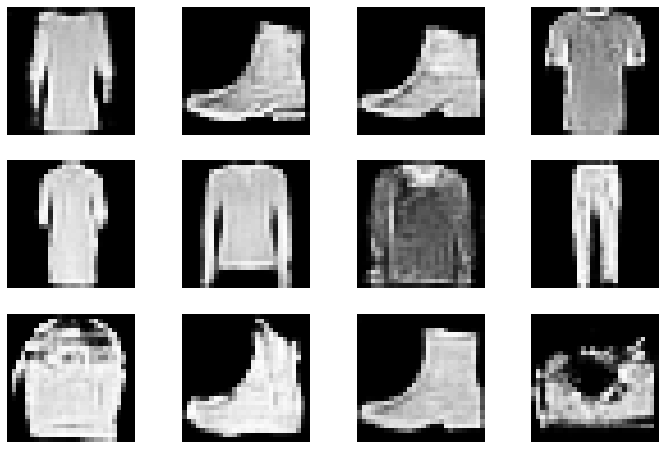

iteration: 89999, gen loss: -39.223915100097656, dis loss: -4.1840972900390625


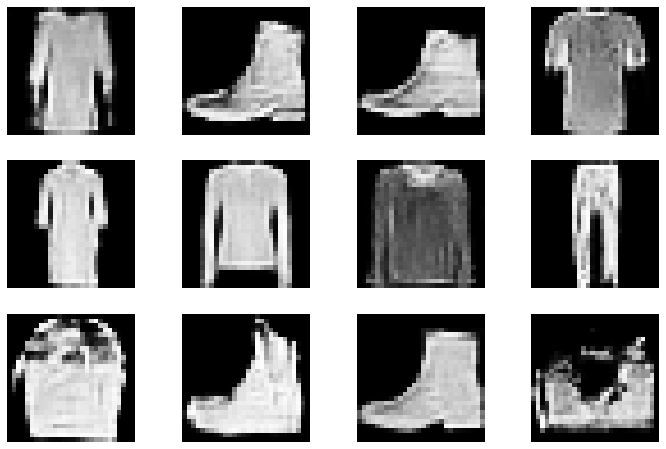

iteration: 94999, gen loss: -54.69486999511719, dis loss: -7.931815147399902


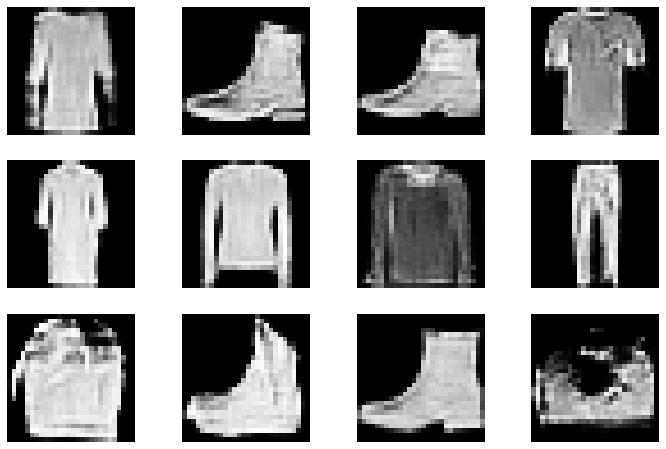

iteration: 99999, gen loss: -53.75928497314453, dis loss: -11.256759643554688


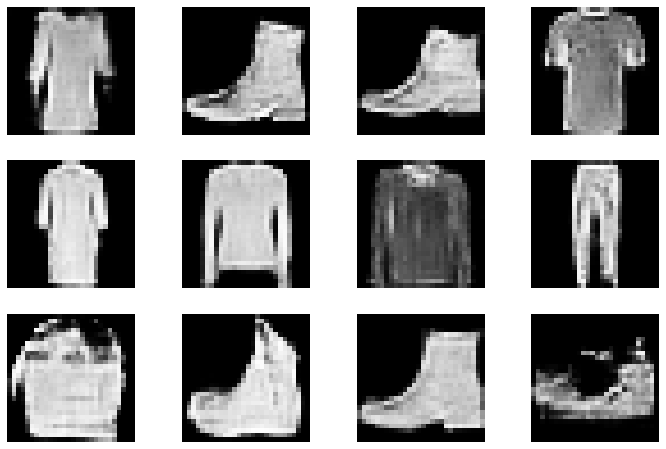

iteration: 104999, gen loss: -69.56749725341797, dis loss: -7.463766098022461


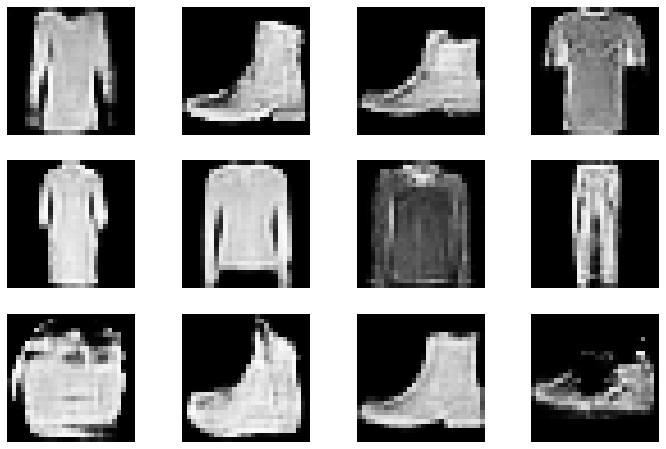

iteration: 109999, gen loss: -73.7704849243164, dis loss: -13.12414836883545


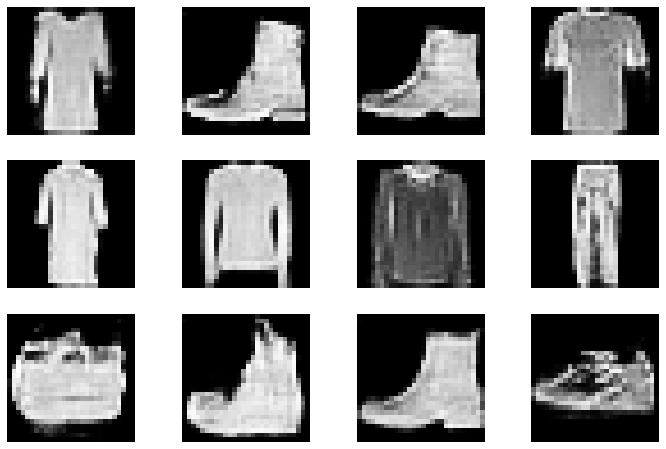

iteration: 114999, gen loss: -36.52043914794922, dis loss: -0.5853039026260376


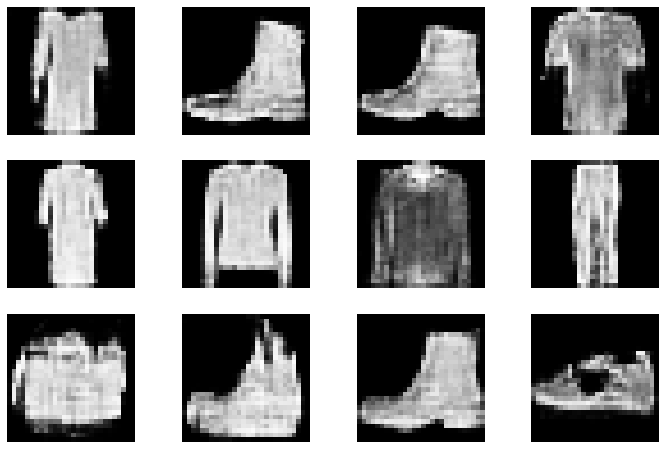

iteration: 119999, gen loss: -30.10108184814453, dis loss: -0.6231210231781006


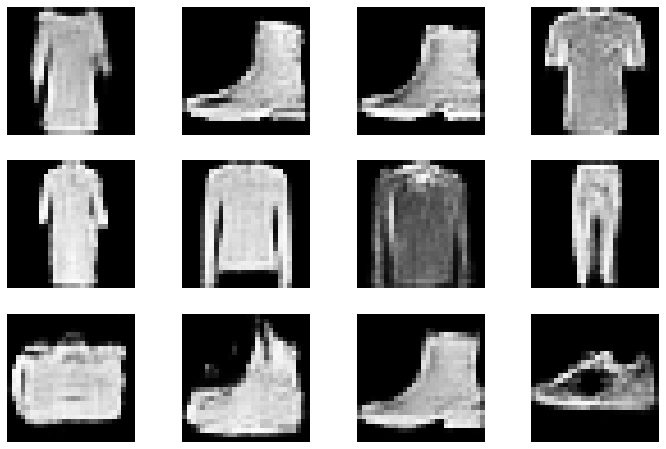

iteration: 124999, gen loss: -22.541725158691406, dis loss: -5.413911819458008


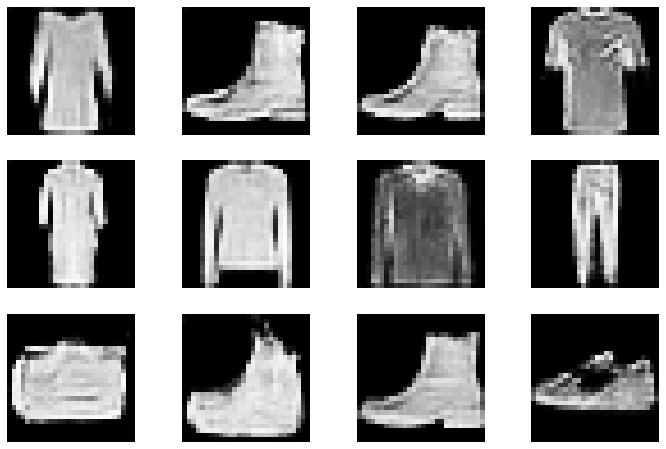

iteration: 129999, gen loss: -23.4189453125, dis loss: -3.5986788272857666


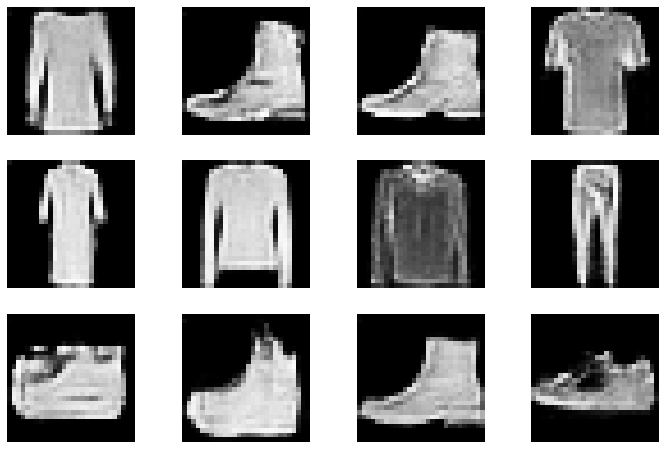

iteration: 134999, gen loss: -17.796306610107422, dis loss: -1.9224650859832764


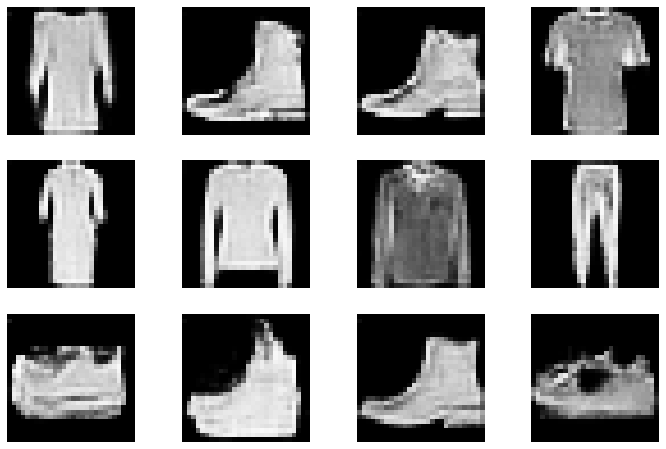

iteration: 139999, gen loss: -18.833202362060547, dis loss: -3.8351972103118896


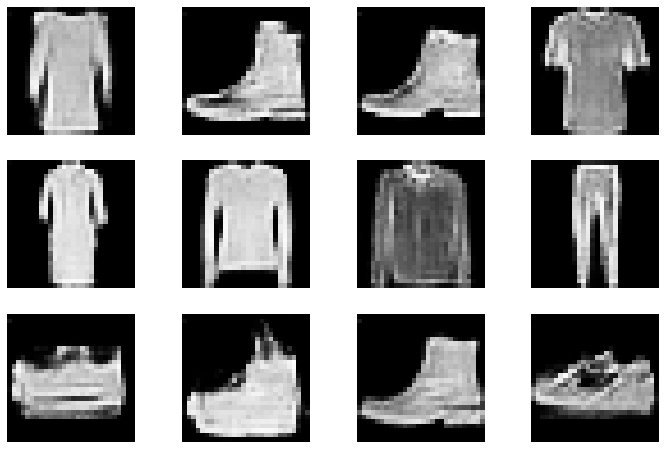

iteration: 144999, gen loss: -9.868478775024414, dis loss: -14.85970687866211


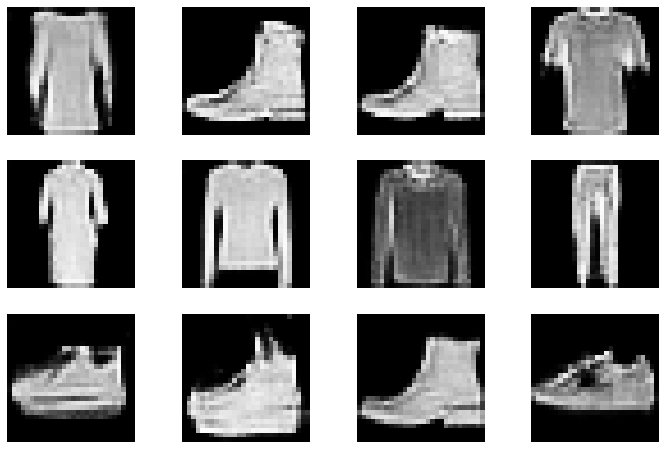

iteration: 149999, gen loss: -13.805331230163574, dis loss: -13.82136344909668


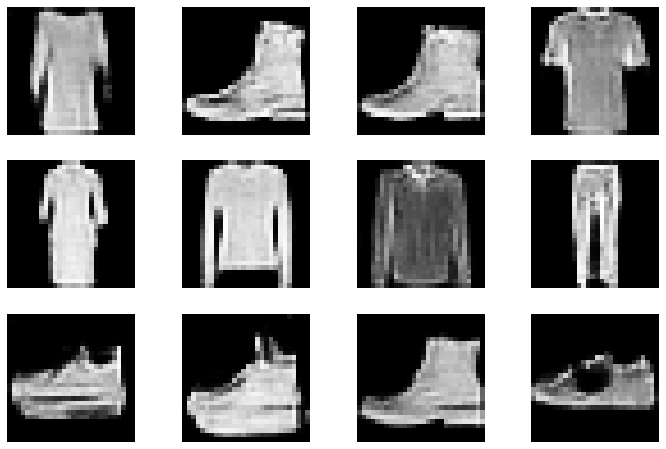

iteration: 154999, gen loss: -21.645263671875, dis loss: -7.5886149406433105


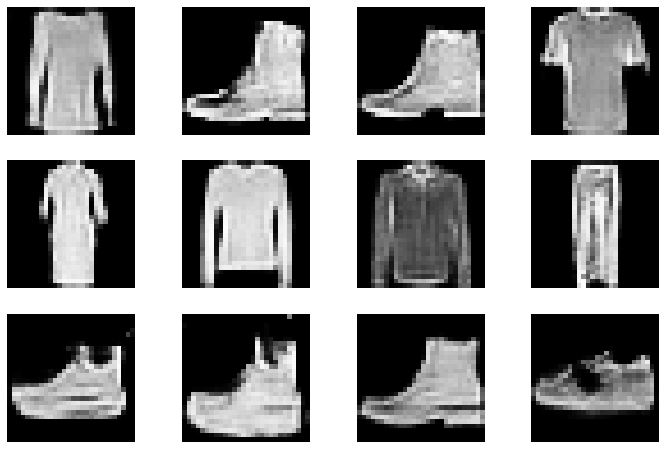

iteration: 159999, gen loss: -19.37003517150879, dis loss: -1.147295355796814


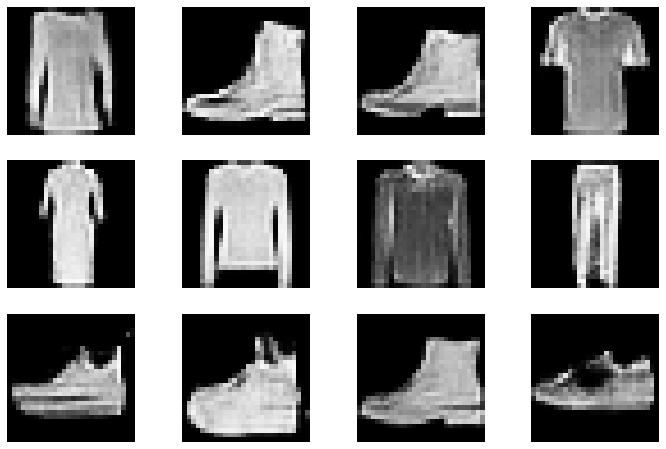

iteration: 164999, gen loss: -29.471647262573242, dis loss: 1.068462610244751


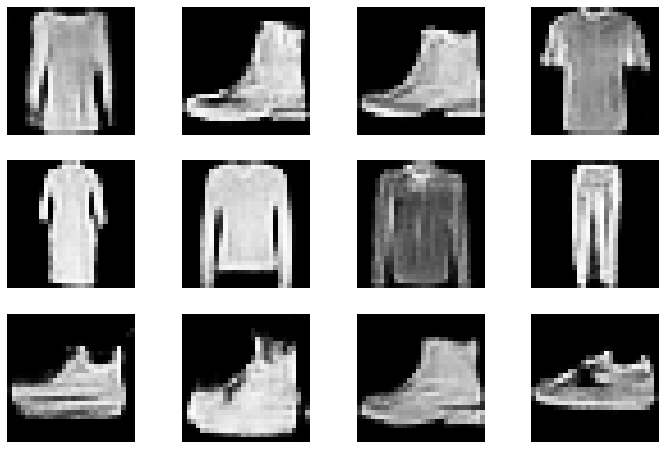

iteration: 169999, gen loss: -27.559803009033203, dis loss: -0.42662763595581055


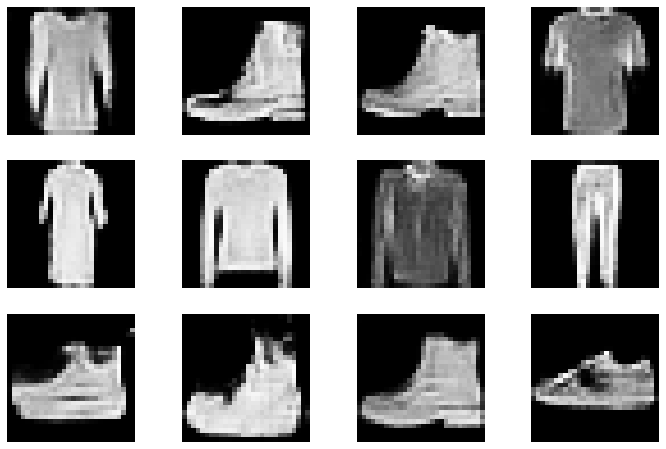

iteration: 174999, gen loss: -26.988903045654297, dis loss: -5.843871116638184


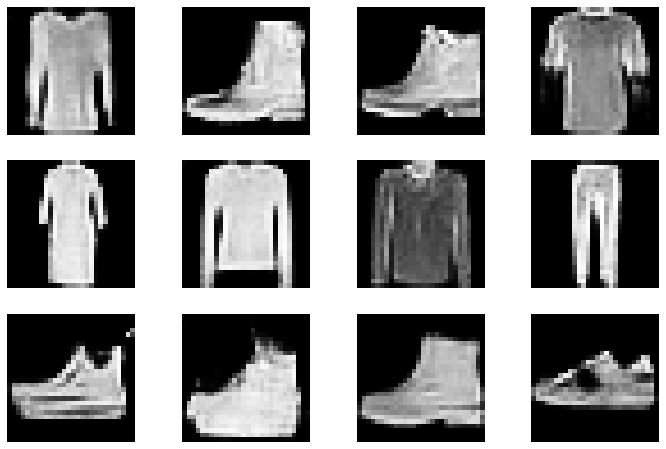

iteration: 179999, gen loss: -20.51785659790039, dis loss: -14.76374340057373


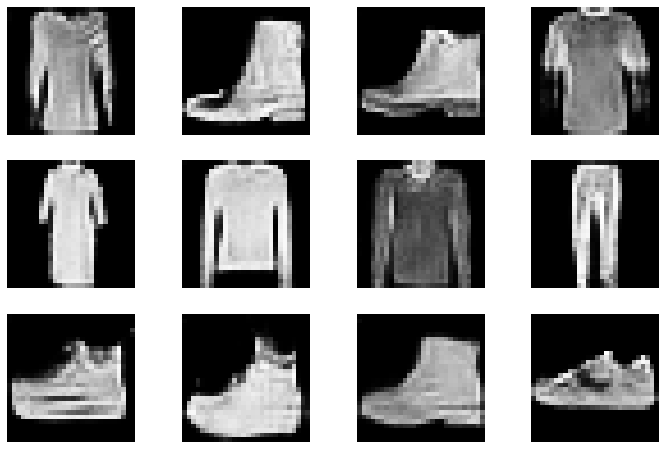

iteration: 184999, gen loss: -28.155351638793945, dis loss: -2.01979660987854


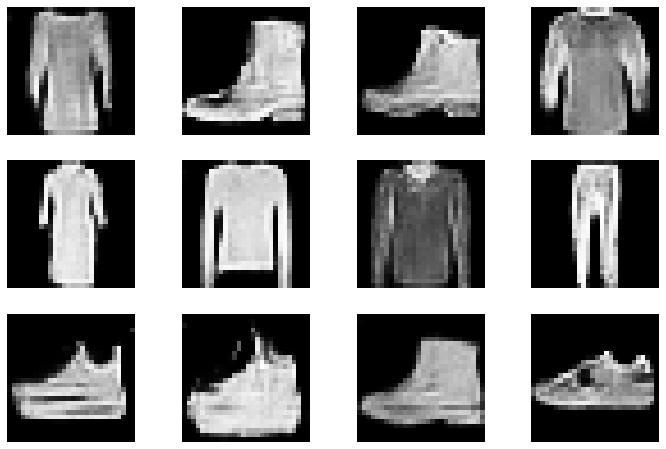

iteration: 189999, gen loss: -26.786394119262695, dis loss: 0.6827616095542908


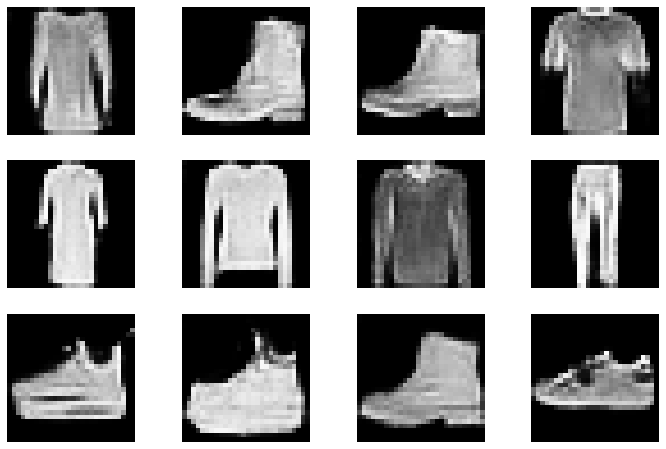

iteration: 194999, gen loss: -28.167404174804688, dis loss: -1.1690242290496826


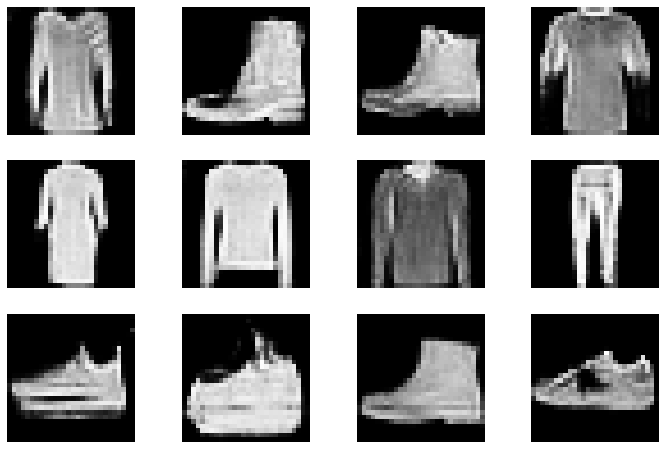

iteration: 199999, gen loss: -35.31759262084961, dis loss: 0.9251484870910645


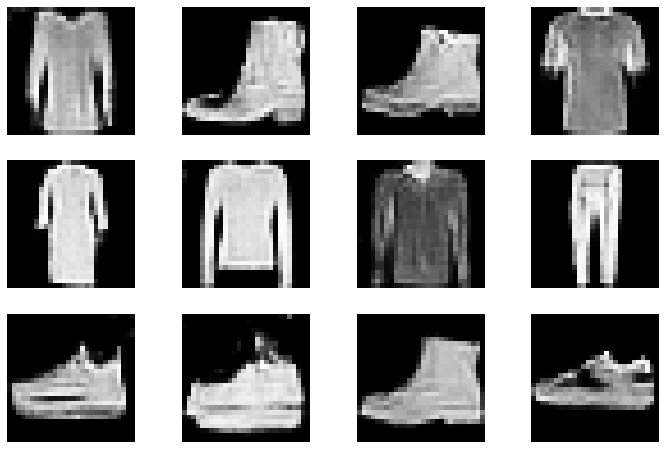

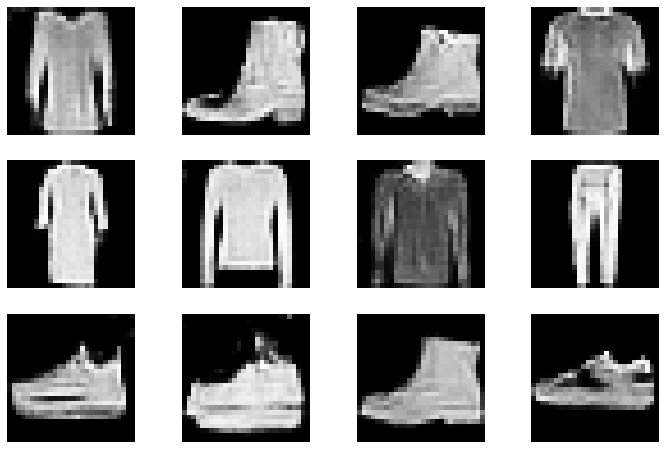

In [ ]:
if not os.path.exists(f"{PATH}/Models/WGAN"):
    os.mkdir(f"{PATH}/Models/WGAN")
if not os.path.exists(f"{PATH}/Results/WGAN"):
    os.mkdir(f"{PATH}/Results/WGAN")

file_name = "WGAN_test"

model = WGAN().to(DEVICE)
results = fit(model, file_name=f"WGAN/{file_name}", save_model=True)

## **Evaluation**

In [21]:
def generate_new_picture(generator_model):
  with torch.no_grad():
      model.eval()
      image = generator_model(batch_size=1)
      plt.imshow(image.cpu().detach().numpy().reshape(28,28), cmap='gray', vmin=-1, vmax=1)
      plt.show()


### **DCGAN**

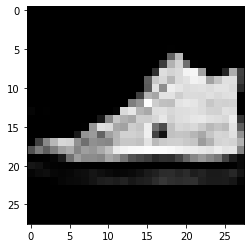

In [28]:

file_name = "DCGAN_trained"
model = DCGAN().to(DEVICE)
model.load_state_dict(torch.load(f"{PATH}/Models/DCGAN/{file_name}.pt", map_location=DEVICE))
generate_new_picture(model.generator)


### **WGAN**

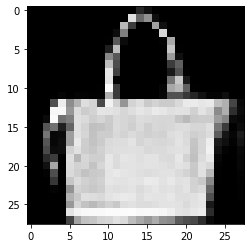

In [29]:

file_name = "WGAN_trained"
model = WGAN().to(DEVICE)
model.load_state_dict(torch.load(f"{PATH}/Models/WGAN/{file_name}.pt", map_location=DEVICE))
generate_new_picture(model.generator)
